# Practical work 7: Split and Merge

In this practical work, we implement and test the split and merge algorithm.

In [1]:
### Usefull libraries
from PIL import Image
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from typing import List, Union
### Data
img_test = np.full((64,64),150,dtype=np.uint8)
img_test[32:48,16:16+32] = 100
img_test[8:24,40:56] = 50
angio = np.array(Image.open('img/angiogra.png'))
cam = np.array(Image.open('img/cameraman.png'))
muscle = np.array(Image.open('img/muscle.png'))
prisme = np.array(Image.open('img/prisme.png'))
seiche = np.array(Image.open('img/seiche.png'))

### Usefull functions
def imshow(I,title=None,size=500):
    """ display an image with a specific size """
    plt.figure(figsize=(size//80,size//80))
    plt.gray()
    plt.imshow(I)
    if title: plt.title(title)
    plt.show()
def neighbors(b,K):
    """ blockStat*list[blockStat]->list[blockStat]
        returns the list of neighbors of b and elements of K 
    """
    def belongsTo(x,y,a):
        """ int*int*BlockStat -> bool 
            Test if pixel (x,y) belongs to block a 
        """
        return x>=a[0] and y>=a[1] and x<a[0]+a[2] and y<a[1]+a[3]
    def areNeighbors(a,b):
        """ BlockStat**2 -> bool
            Test if a and b are neighbors
        """
        if a[2]>b[2] and a[3]>b[3]:
            a,b=b,a
        x,y = a[0]+a[2]//2,a[1]+a[3]//2
        return belongsTo(x+a[2],y,b) or belongsTo(x-a[2],y,b) or belongsTo(x,y+a[3],b) or belongsTo(x,y-a[3],b)
    return [n for n in K if areNeighbors(b,n)]


## Exercise 1

### Question 1
Write the recursive function ``split()`` discussed in tutorial work. 
It takes as input the image, a region, a predicate, and a variable number of arguments. 
The region is a Python formal type ``Block`` defined by:
```python
type Block = tuple[int**4]
```
The function ``split()`` returns a quadtree, a Python formal type, recursivelly defined by:
```python
type QuadTree = list[(QuadTree**4|Block)] 
```

The predicate is a Python function with the following signature:
```python
Array*Block*...->bool
```
It can take a variable number of parameters which correspond to the parameters required by the predicate.

In [2]:
def split(I, reg, pred, *args):
    x, y, w, h = reg
    
    if pred(I, reg, *args) and (w >= 2 or h >= 2):  # continue splitting if predicate is true
        half_w, half_h = w // 2, h // 2
        return [
            split(I, (x, y, half_w, half_h), pred, *args),
            split(I, (x, y + half_h, half_w, half_h), pred, *args),
            split(I, (x + half_w, y, half_w, half_h), pred, *args),
            split(I, (x + half_w, y + half_h, half_w, half_h), pred, *args)
        ]
    else:
        return [reg]
    

### Question 2
Write the function ```predsplit(I,B,*args)``` with signature:
```python
Array*Block*... -> bool
```
that returns True if the standard deviation of image ``I`` computed in region ``B`` is greater than the first value of argument ``*args`` (it can be accessed simply by ``*args[0]``).

In [3]:
def predsplit(I, reg, *args):
    """ Array*Block*... -> bool
        Returns True if the standard deviation in region reg of image I 
        is greater than a specified threshold (args[0]).
    """
    x, y, w, h = reg  # Unpack the block's coordinates and size
    region = I[x:x+w,y:y+h]  # Extract the region from the image
    threshold = args[0]  # The threshold for standard deviation
    return np.std(region) > threshold


### Question 3
Write the function ``listRegions()`` which applies a depth-first search on the quadtree given as parameter, and returns the list of the leaves of the quadtree. 

Some recalls about lists in Python;
 - Initialization: `L = []` (empty list)
 - Add a element `a` into a list `L`: `L.append(a)`

In [4]:
def listRegions(Q):
    """ QuadTree -> list[Block]
        Returns a list of the leaves of the quadtree.
    """
    leaves = []  # Initialize an empty list for the leaves
    for element in Q:
        if isinstance(element, tuple):
            # If the element is a Block (tuple), add it to the list
            leaves.append(element)
        else:
            # If the element is a QuadTree, recurse and extend the leaves list
            leaves.extend(listRegions(element))
    return leaves

### Question 4
Test your codes on the synthetic image ``img_test`` seen in tutorial work. Print the value returned by ``split()`` as well as the one returned by ``listRegions()``. 

In [5]:
threshold = 10  

quadtree = split(img_test, (0, 0, img_test.shape[1], img_test.shape[0]), predsplit, threshold)

regions = listRegions(quadtree)

print("Quadtree:")
print(quadtree)
print("\nLeaf Regions:")
print(regions)

Quadtree:
[[(0, 0, 32, 32)], [[[(0, 32, 8, 8)], [(0, 40, 8, 8)], [(8, 32, 8, 8)], [(8, 40, 8, 8)]], [[(0, 48, 8, 8)], [(0, 56, 8, 8)], [(8, 48, 8, 8)], [(8, 56, 8, 8)]], [[(16, 32, 8, 8)], [(16, 40, 8, 8)], [(24, 32, 8, 8)], [(24, 40, 8, 8)]], [[(16, 48, 8, 8)], [(16, 56, 8, 8)], [(24, 48, 8, 8)], [(24, 56, 8, 8)]]], [[(32, 0, 16, 16)], [(32, 16, 16, 16)], [(48, 0, 16, 16)], [(48, 16, 16, 16)]], [[(32, 32, 16, 16)], [(32, 48, 16, 16)], [(48, 32, 16, 16)], [(48, 48, 16, 16)]]]

Leaf Regions:
[(0, 0, 32, 32), (0, 32, 8, 8), (0, 40, 8, 8), (8, 32, 8, 8), (8, 40, 8, 8), (0, 48, 8, 8), (0, 56, 8, 8), (8, 48, 8, 8), (8, 56, 8, 8), (16, 32, 8, 8), (16, 40, 8, 8), (24, 32, 8, 8), (24, 40, 8, 8), (16, 48, 8, 8), (16, 56, 8, 8), (24, 48, 8, 8), (24, 56, 8, 8), (32, 0, 16, 16), (32, 16, 16, 16), (48, 0, 16, 16), (48, 16, 16, 16), (32, 32, 16, 16), (32, 48, 16, 16), (48, 32, 16, 16), (48, 48, 16, 16)]


### Question 5
Write the function ```drawRegions(L,I)``` which takes as arguments a list of regions, an image, and returns an image  where the boundaries of each region have been traced with red color. Indication: the returned image is a hypermatrix of dimension 3, the third dimension is of size 3 and encodes the red, green and blue components of a RGB colorspace. Test the function on the previous example.

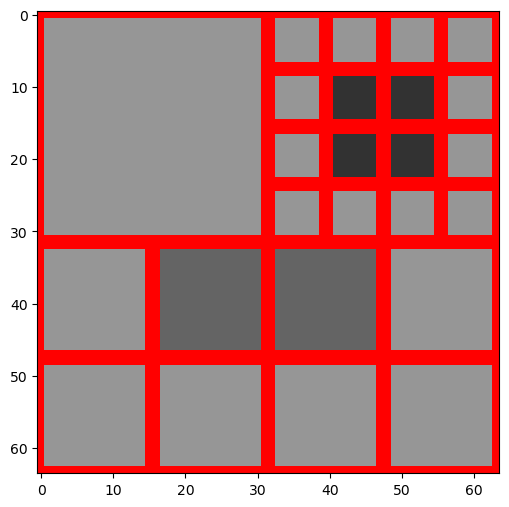

In [6]:
def drawRegions(LL, I):
    """ list[Block]*Array -> Array
        Traces the boundaries of each region in LL on image I in red color.
    """
    # Convert the grayscale image to RGB
    RGB = np.stack((I,)*3, axis=-1)

    # Define the color red (for the boundaries)
    red = [255, 0, 0]

    for reg in LL:
        x, y, w, h = reg
        # Draw top boundary
        RGB[ x:x+w,y, :] = red
        # Draw bottom boundary
        RGB[ x:x+w,y+h-1, :] = red
        # Draw left boundary
        RGB[ x,y:y+h, :] = red
        # Draw right boundary
        RGB[ x+w-1,y:y+h, :] = red

    return RGB
result_image = drawRegions(regions, img_test)

imshow(result_image)


### Question 6
Add a Gaussian noise with standard deviation 5 to the image ``img_test``. 
Apply the quadtree splitting on the noisy image by adjusting the threshold to obtain the same result as in the previous question. 
Which threshold value should be chosen? Does this make sense to you?

Hint: use the Numpy function ``random.randn()`` which generates random values according to a normal distribution (Gaussian distribution of null mean and variance 1). To obtain realizations of a Gaussian distribution of standard deviation $\sigma$, it is sufficient to multiply by $\sigma$ the realizations of a normal distribution. 

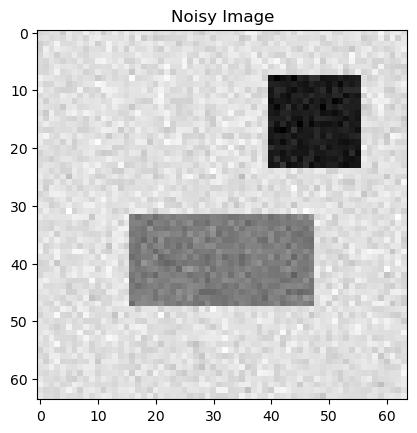

Threshold: 10, Number of Regions: 25
Threshold: 15, Number of Regions: 25
Threshold: 20, Number of Regions: 25
Threshold: 25, Number of Regions: 19
Threshold: 30, Number of Regions: 1


In [7]:
noisy_img_test = img_test + np.random.randn(*img_test.shape) * 5


# Display the noisy image
plt.imshow(noisy_img_test, cmap='gray')
plt.title("Noisy Image")
plt.show()
thresholds_to_test = [10, 15, 20, 25, 30]  # range of thresholds to test

for threshold in thresholds_to_test:
    quadtree_noisy = split(noisy_img_test, (0, 0, noisy_img_test.shape[1], noisy_img_test.shape[0]), predsplit, threshold)
    regions_noisy = listRegions(quadtree_noisy)
    print(f"Threshold: {threshold}, Number of Regions: {len(regions_noisy)}")



## Exercise 2

Experiment the split algorithm on the 4 natural images provided. For each image try to find the threshold that seems to you visually the best. Display the number of regions obtained after splitting.

Testing thresholds for image 1
Threshold: 10, Number of regions: 8356


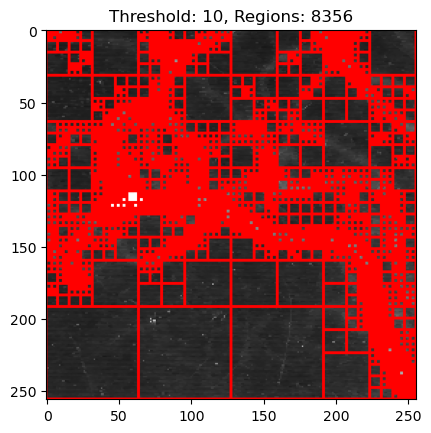

Threshold: 15, Number of regions: 3748


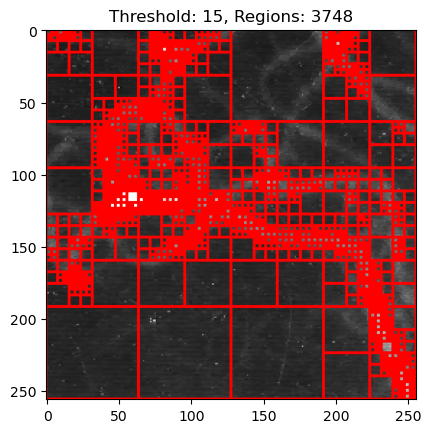

Threshold: 20, Number of regions: 1711


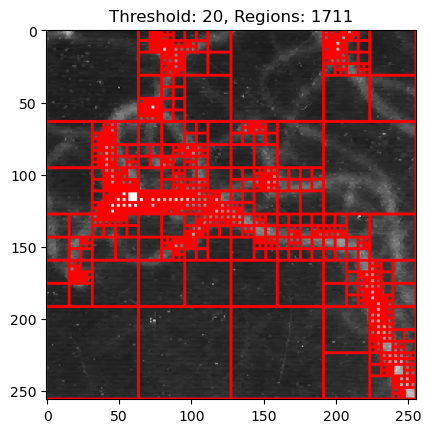

Testing thresholds for image 2
Threshold: 10, Number of regions: 14635


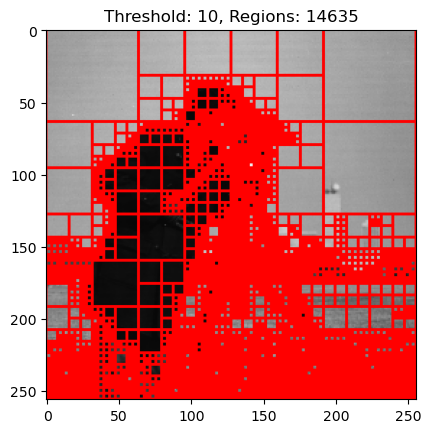

Threshold: 15, Number of regions: 9328


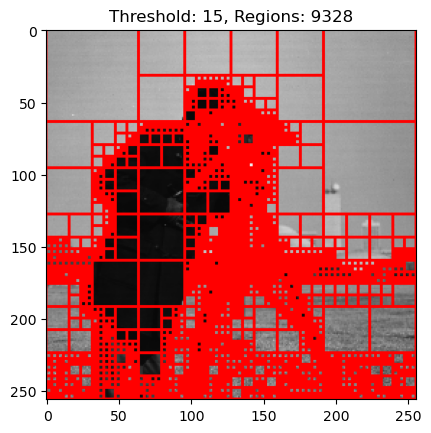

Threshold: 20, Number of regions: 6340


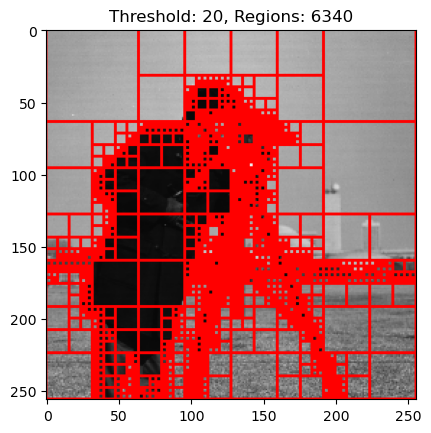

Testing thresholds for image 3
Threshold: 10, Number of regions: 20908


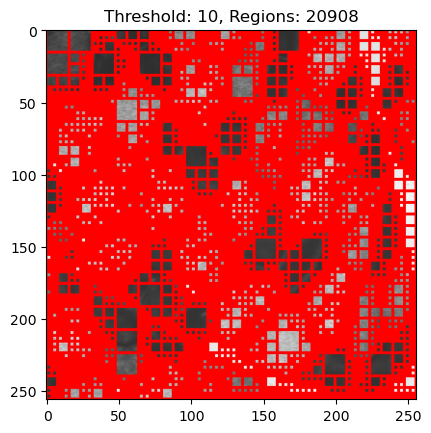

Threshold: 15, Number of regions: 11512


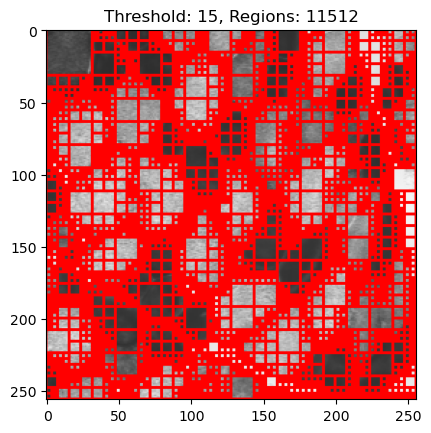

Threshold: 20, Number of regions: 7612


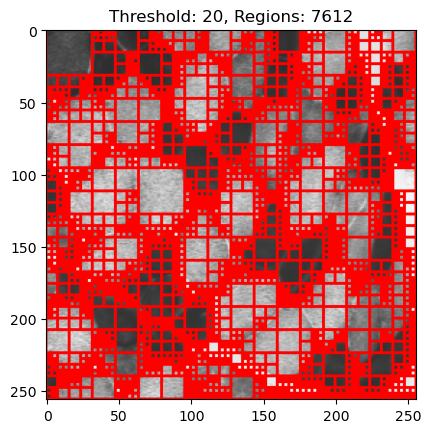

Testing thresholds for image 4
Threshold: 10, Number of regions: 13456


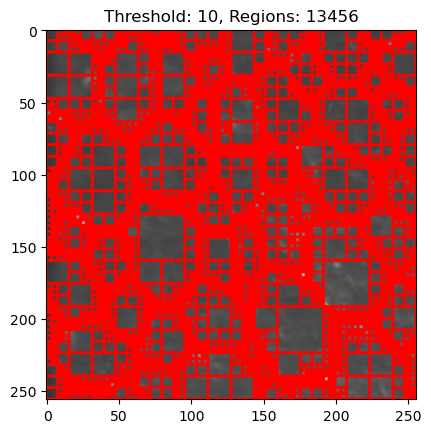

Threshold: 15, Number of regions: 7459


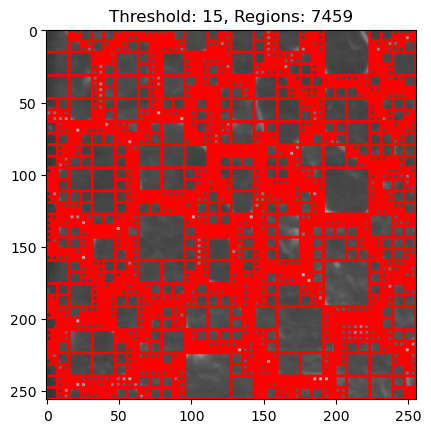

Threshold: 20, Number of regions: 3292


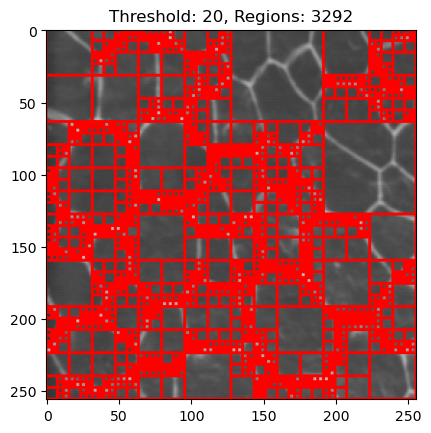

Testing thresholds for image 5
Threshold: 10, Number of regions: 7579


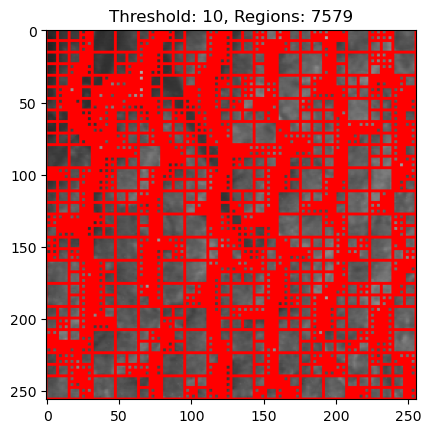

Threshold: 15, Number of regions: 2875


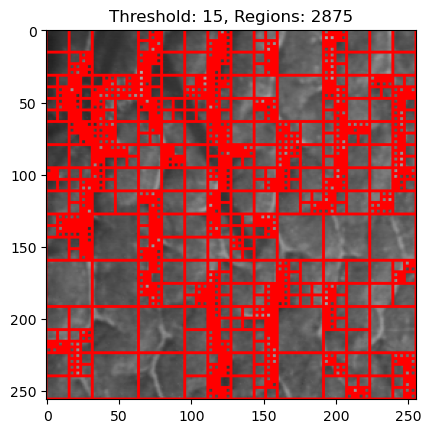

Threshold: 20, Number of regions: 478


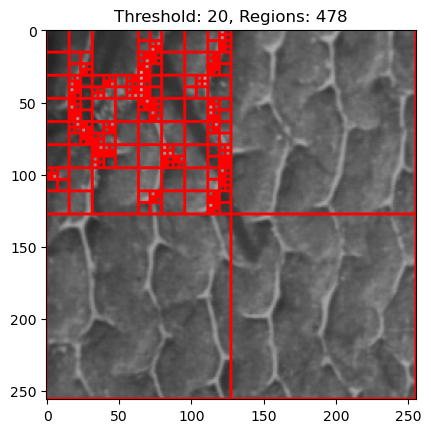

In [8]:
images = [angio, cam, muscle, prisme, seiche]
thresholds = np.arange(10, 25, 5)

for i, img in enumerate(images):
    print(f"Testing thresholds for image {i+1}")
    for threshold in thresholds:
        quadtree = split(img, (0, 0, img.shape[1], img.shape[0]), predsplit, threshold)
        leaves = listRegions(quadtree)
        print(f"Threshold: {threshold}, Number of regions: {len(leaves)}")
        #visualizing the regions
        img_with_regions = drawRegions(leaves, img)
        plt.imshow(img_with_regions, cmap='gray')
        plt.title(f"Threshold: {threshold}, Regions: {len(leaves)}")
        plt.show()
 





## Exercise 3
### Question 1
Modify the function ``listRegions(L)`` to make it a function ``listRegionsStat(L,I)`` which computes the list of leaves of the quadtree ``L``. Each element of this list will be enriched with three scalar values: the first being the size, the second the mean and the third the variance of pixel values of the block in the image ``I``. This function then returns a list whose elements have the following formal type:
```python
type BlockStat = tuple[int**4,int,float**2]
```

The first four values are those of the ``Block`` type, the fifth is the size of the block (in number of pixels) and the last two values are the mean and variance calculated over the region.

In [9]:
def listRegionsStat(L, I):
    """ QuadTree*Array -> list[BlockStat]
        Computes the list of leaves of the quadtree L with additional statistics.
    """
    block_stats = []
    for element in L:  # Iterate through each element in the quadtree list
        if isinstance(element, tuple):
            x, y, w, h = element
            block_region = I[x:x+w, y:y+h]
            block_size = w * h
            block_mean = np.mean(block_region)
            block_variance = np.var(block_region)
            block_stat = (x, y, w, h, block_size, block_mean, block_variance)
            block_stats.append(block_stat)
        else: # If the element is not a leaf block (it's a nested list/subtree)
            block_stats.extend(listRegionsStat(element, I))
    return block_stats

### Question 2
In the remainder, the formal type is considered:
```python
type Region = list[BlocStats]
```
A region, as seen during the tutorial work, is therefore a list of blocks. Write the predicate ``predmerge(b,R,*args)`` as seen in tutorial work. This function returns ``True`` if the ``b`` block should merge into the ``R`` region. If a merge happens, then the first item of ``R`` will have its statistics updated to describe the statistics of the region ``R`` merged with `b`.

In [22]:
def predmerge(b, R, *args):
    """ BlockStat*Region*... -> bool 
        If merge, R[0] is modified
    """
    threshold = args[0]
    if not R:
        return False
    mean_diff = abs(R[0][5] - b[5])
    if mean_diff <= threshold:
        #Modify R[0] to describe the region
        total_size = R[0][4] + b[4]
        new_mean = (R[0][5] * R[0][4] + b[5] * b[4]) / total_size
        new_variance = ((R[0][6] * R[0][4]) + (b[6] * b[4])) / total_size
        R[0] = (R[0][0], R[0][1], R[0][2], R[0][3], total_size, new_mean, new_variance)
        return True
    return False


### Question 3
Using `predmerge()` and `neighbors()` functions, given at the beginning of the notebook, write the function ``merge()`` discussed in tutorial work (exercise 7.6).

Recalls on Python lists:
- Remove an element `a` from a list `L`: `L.remove(a)`
- Test if `a` belongs to a list `L`: `a in L` 
- Iterate the elements of a list `L`: `for a in L:`
- Access to an element of a list: as with numpy arrays

In [11]:
def merge(I,reg,pred,*args):
    k = listRegionsStat(I,reg)  # Extract blocks from the quadtree S as the initial list of leaves
    L = []  # Initialize the list of merged regions

    while k:
        b = k.pop(0)  # Take the first block from the list
        R = [b]  # Start a new region with this block
        W = neighbors(b, k)  # Find neighbors of b within the list k

        for bn in W:
            if predmerge(bn, R, *args):  # Use predmerge to decide if bn should merge with R
                k.remove(bn)  # Remove bn from the list if merging
                R.append(bn)  # Add bn to the current region R

        L.append(R)  # Add the current region R to the list of merged regions L

    mean_to_regions = {}
    for region in L:
        region_mean = round(np.mean([block[5] for block in region]), 2)  # Calculate and round the mean for comparison
        if region_mean not in mean_to_regions:
            mean_to_regions[region_mean] = region
        else:
            mean_to_regions[region_mean].extend(region)  # Merge regions with the same mean

    # Extract merged regions from the dictionary
    merged_L = list(mean_to_regions.values())

    return merged_L


### Question 4
Test the previous functions using the synthetic image `img_test`. In particular, check that merge() returns a list of 3 elements (i.e. 3 regions).

In [12]:
merge_threshold = 10
quadtree = split(img_test, (0, 0, img_test.shape[1], img_test.shape[0]), predsplit, merge_threshold)
merged_regions = merge(quadtree, img_test, predmerge, merge_threshold)

num_merged_regions = len(merged_regions)
print(f"Number of merged regions: {num_merged_regions}")

Number of merged regions: 3


### Question 5
Write a function ``regions(LR,shape)`` that takes as arguments a list of regions (such as returned by the function ``merge()``) and an image size, and returns an image of the regions. Each region will be colored with the gray level corresponding to the average of the region. The ``shape`` parameter gives the size of the image to be produced. 

Test the function on the previous example.

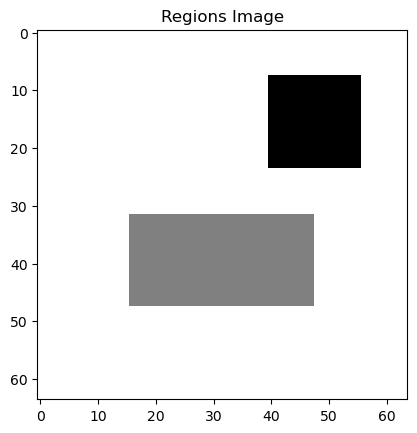

In [13]:
def regions(LR, shape):
    """ list[Region]*tuple[int,int] -> Array
        Creates an image from a list of regions, coloring each region with its average gray level.
    """
    # Create an empty image
    img = np.zeros(shape, dtype=np.uint8)

    for region in LR:
        for block in region:
            x, y, w, h, _, mean, _ = block  # Unpack the block
            img[x:x+w, y:y+h] = mean  # Fill the block area with the mean gray level

    return img

# Testing the function with the merged regions and the shape of img_test
region_image = regions(merged_regions, img_test.shape)

plt.imshow(region_image, cmap='gray')
plt.title("Regions Image")
plt.show()


## Exercise 4: experiments
### Question 1
Test the function ``merge()`` on the images ``angio``, ``cam``, ``muscle``, ``prisme`` and ``seiche``. Try to produce the best segmentations.

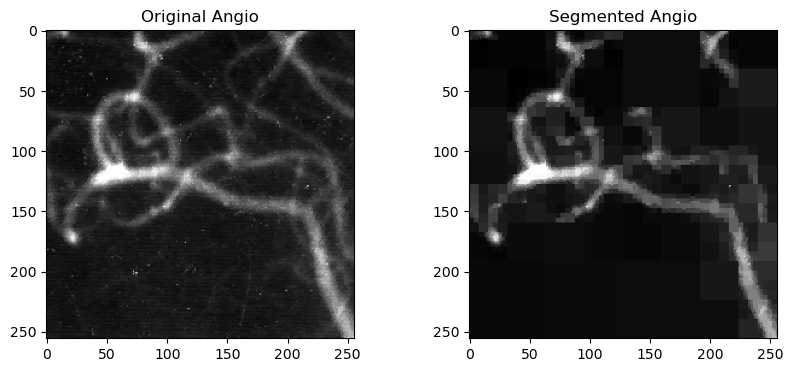

In [14]:
# Angio Image Segmentation
threshold_angio = 16

quadtree_angio = split(angio, (0, 0, angio.shape[0], angio.shape[1]), predsplit, threshold_angio)
merged_regions_angio = merge(quadtree_angio, angio, predmerge, threshold_angio)
region_image_angio = regions(merged_regions_angio, angio.shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(angio, cmap='gray')
plt.title("Original Angio")
plt.subplot(1, 2, 2)
plt.imshow(region_image_angio, cmap='gray')
plt.title("Segmented Angio")
plt.show()



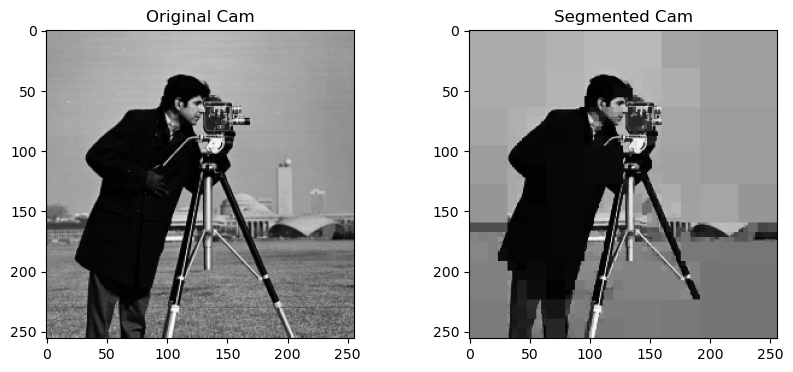

In [15]:

# Cam Image Segmentation
threshold_cam = 28  

quadtree_cam = split(cam, (0, 0, cam.shape[0], cam.shape[1]), predsplit, threshold_cam)
merged_regions_cam = merge(quadtree_cam, cam, predmerge, threshold_cam)
region_image_cam = regions(merged_regions_cam, cam.shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cam, cmap='gray')
plt.title("Original Cam")
plt.subplot(1, 2, 2)
plt.imshow(region_image_cam, cmap='gray')
plt.title("Segmented Cam")
plt.show()

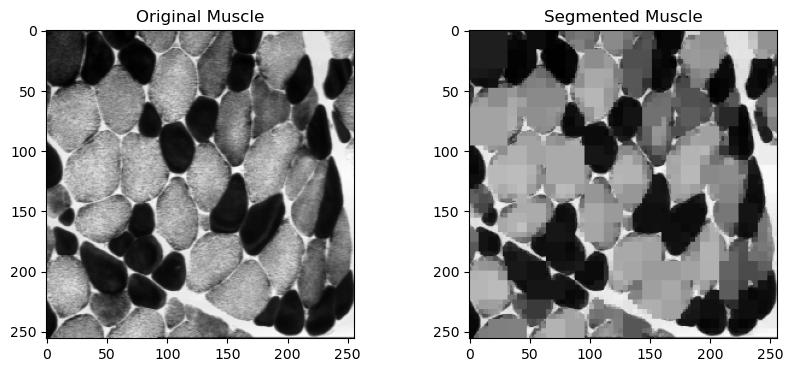

In [16]:
# Muscle Image Segmentation
threshold_muscle = 21  

quadtree_muscle = split(muscle, (0, 0, muscle.shape[0], muscle.shape[1]), predsplit, threshold_muscle)
merged_regions_muscle = merge(quadtree_muscle, muscle, predmerge, threshold_muscle)
region_image_muscle = regions(merged_regions_muscle, muscle.shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(muscle, cmap='gray')
plt.title("Original Muscle")
plt.subplot(1, 2, 2)
plt.imshow(region_image_muscle, cmap='gray')
plt.title("Segmented Muscle")
plt.show()


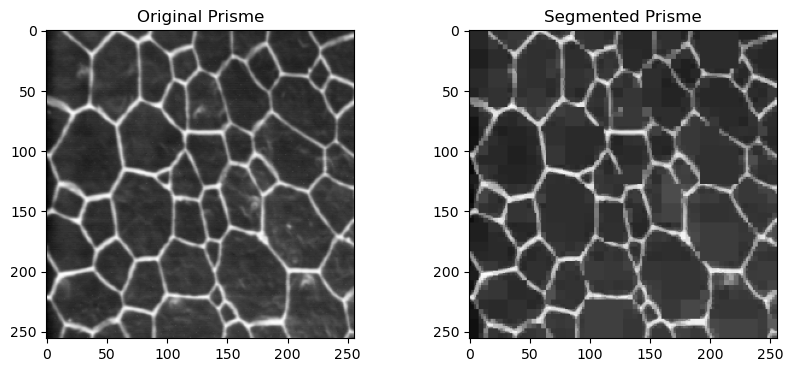

In [17]:
# Prisme Image Segmentation
threshold_prisme = 15

quadtree_prisme = split(prisme, (0, 0, prisme.shape[0], prisme.shape[1]), predsplit, threshold_prisme)
merged_regions_prisme = merge(quadtree_prisme, prisme, predmerge, threshold_prisme)
region_image_prisme = regions(merged_regions_prisme, prisme.shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(prisme, cmap='gray')
plt.title("Original Prisme")
plt.subplot(1, 2, 2)
plt.imshow(region_image_prisme, cmap='gray')
plt.title("Segmented Prisme")
plt.show()


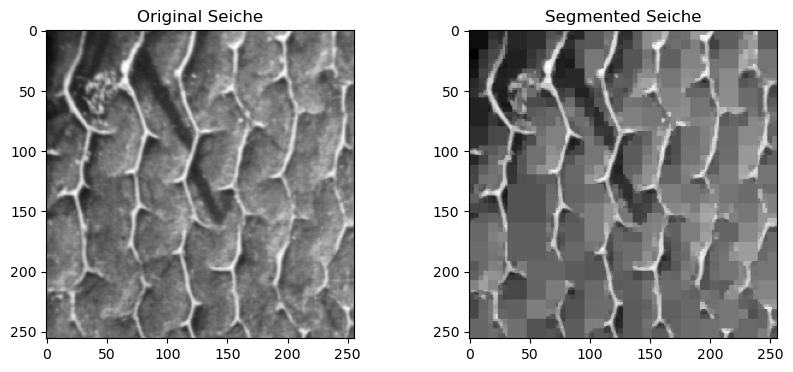

In [21]:
# Seiche Image Segmentation
threshold_seiche = 11 

quadtree_seiche = split(seiche, (0, 0, seiche.shape[0], seiche.shape[1]), predsplit, threshold_seiche)
merged_regions_seiche = merge(quadtree_seiche, seiche, predmerge, threshold_seiche)
region_image_seiche = regions(merged_regions_seiche, seiche.shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(seiche, cmap='gray')
plt.title("Original Seiche")
plt.subplot(1, 2, 2)
plt.imshow(region_image_seiche, cmap='gray')
plt.title("Segmented Seiche")
plt.show()

### Question 2
The result of the merge algorithm highly depends on how you visit the regions. One can then sort the leaves of the quadtree, for example, from the smallest to the largest blocks, or the opposite (use the Python function ``sorted()``). 
The same question arises when calculating the set of neighbors of the merged region. Should they be sorted? If yes, according to which criteria? their size? their proximity? 
Obviously there is no universal answer but it should be adapted to each type of problem. 
Do some tests to see the influence of these sortings on the result of the merger.

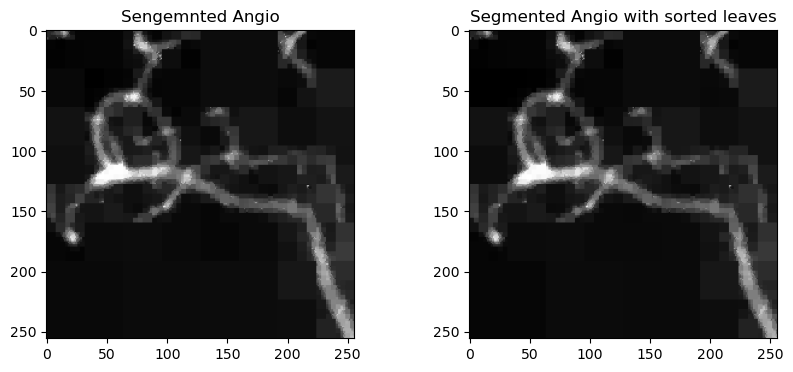

In [19]:
def merge_sort(S,I,pred,*args):
    k = sorted(listRegionsStat(S, I), key=lambda x: x[2] * x[3]) # Initialize with blocks having statistical data
    L = []  # Initialize the list of merged regions

    while k:
        b = k.pop(0)  # Take the first block from the list
        R = [b]  # Start a new region with this block
        W = neighbors(b, k)  # Find neighbors of b within the list k

        for bn in W:
            if predmerge(bn, R, *args):  # Use predmerge to decide if bn should merge with R
                k.remove(bn)  # Remove bn from the list if merging
                R.append(bn)  # Add bn to the current region R

        L.append(R)  # Add the current region R to the list of merged regions L

    mean_to_regions = {}
    for region in L:
        region_mean = round(np.mean([block[5] for block in region]), 2)  # Calculate and round the mean for comparison
        if region_mean not in mean_to_regions:
            mean_to_regions[region_mean] = region
        else:
            mean_to_regions[region_mean].extend(region)  # Merge regions with the same mean

    # Extract merged regions from the dictionary
    merged_L = list(mean_to_regions.values())

    return merged_L




# Angio Image Segmentation
threshold_angio = 16 # Customizable based on observation

quadtree_angio = split(angio, (0, 0, angio.shape[0], angio.shape[1]), predsplit, threshold_angio)
merged_regions_angio = merge(quadtree_angio, angio, predmerge, threshold_angio)
region_image_angio = regions(merged_regions_angio, angio.shape)

quadtree_angio_sort = split(angio, (0, 0, angio.shape[0], angio.shape[1]), predsplit, threshold_angio)
merged_regions_angio_sort = merge_sort(quadtree_angio, angio, predmerge, threshold_angio)
region_image_angio_sort = regions(merged_regions_angio_sort, angio.shape)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(region_image_angio, cmap='gray')
plt.title("Sengemnted Angio")
plt.subplot(1, 2, 2)
plt.imshow(region_image_angio_sort, cmap='gray')
plt.title("Segmented Angio with sorted leaves")
plt.show()


#We can observe a difference in segmentation when sorting the leaves, 
#It might influence the merge outcome by prioritizing certain regions for merging based on size,
#which could lead to different segmentation granularity.

#After tests with varying the neighbors, by substituting W by W = sorted(W, key=lambda x: x[2] * x[3])
#which sorts neighbors from smallest to largest by size (w*h) 
#Prioritizing smaller blocks captured finer details,
#while starting with larger blocks (by adding reverse = True)favored broad homogeneity.
#Sorting by proximity (e.g., distance between the centers of blocks) 
#ensures that the merging process prioritizes blocks that are not only similar according to the merging criterion
#but also close to each other

### Question 3 (bonus)
Imagine and experiment alternative predicates for both the split and the merge steps. It is possible to use edges-based predicates, and also to combine with variance-based predicates.
